## ILC Part

I just copied some parts of the notebook from 
[learning explanations that are hard to vary](https://github.com/gibipara92/learning-explanations-hard-to-vary) github to play with.

In [1]:
import torch
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
np.set_printoptions(precision=5, suppress=True)

In [ ]:
ADD_SMALL_NOISE = False

# Create the dataset.
x = 3 * torch.cat((torch.eye(4), 0.1 * torch.ones(4).view(-1,1)), dim=1)
y = torch.tensor([1., 1., 1., 1.]).float()

if ADD_SMALL_NOISE:
    dist = torch.distributions.Uniform(-0.001, 0.001)
    
    # This adds noise on all non-robust feature
    x[:, :-1] += dist.sample(x[:, :-1].shape)
    
    # This adds noise on every feature
    #     x += dist.sample(x.shape)

print('x:', x.numpy(), sep="\n")
print('y: ', y.view(-1, 1).numpy(), sep="\n")

x:
[[3.  0.  0.  0.  0.3]
 [0.  3.  0.  0.  0.3]
 [0.  0.  3.  0.  0.3]
 [0.  0.  0.  3.  0.3]]
y: 
[[1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
a = np.array([[1,2],[3,4]])
a.view(-1,1)

ValueError: ignored

## FMRI Part

You might need to upload the files into the collab directory. The files used in this script are located inside the example dataset folder : 
 

*   sub-01/func/sub-01_task-stopsignal_run-01_bold.nii.gz
*   sub-02/func/sub-02_task-stopsignal_run-01_bold.nii.gz


### My understanding of the problem and steps we need to take:

#### **The traditional approach**

The traditional approach to handling fMRI data is to regress the signal of each voxel with the convolution of their step response with the Haemodynamic response (HRF). Let's say we got an experiment in which the subject's repsonse could be a choice among $k$ categories (for instance north, south, east, and west). Each category has a BOLD impulse response or HRF. When measuring the subject's response, we get a sequence of step functions for ***each voxel*** (something like the figure below, ***but in our case is it spike/sec? Or just binary valued steps?***). To get the BOLD response, we would then convolve this function with the HRF of all categories (As the system is LTI, we're convolving the input with the impulse response to get the output, in some sense it accounts for the time dependence of the brain response to earlier activities). ***Is y in our data like the figure on the right or the left?*** 

  Traditionally they construct a **Design Matrix $X^{T\times |categories|}$**, where $T$ refers to the timesteps. $X_{ij}$ determines the effect of category $j$ on the signal of a specific voxel at time $i$ (***I'm not sure how exactly it's quantified.***). Then they solve a GLM for each voxel $y^{(i)}=X.\beta^{(i)}$

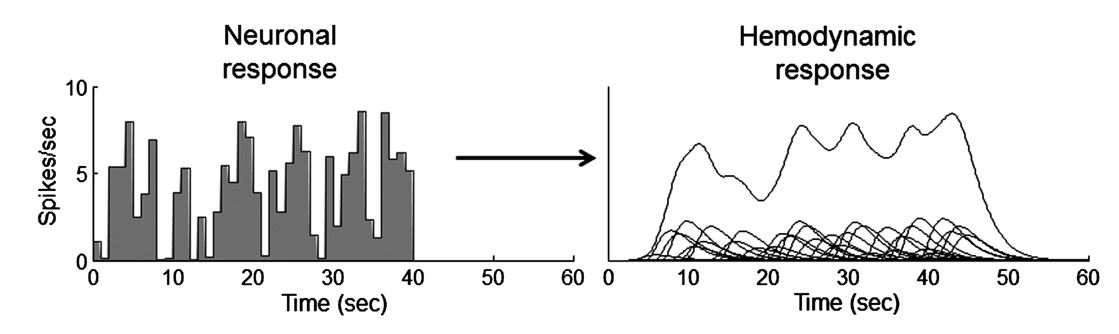

Figure adapted from Guillame Flandin's Slides (UCL)

#### **Our approach**
In my understanding our target variable is whether an action is taken or not (perhaphs again among a set of $k$ categorical choices). Then the whole signal $y$ over time would be something like the figure on the left, *where this time the vertical axis is not spikes/sec, rather they're just binary values*. ***So would we get any smoothing/convolution with HRF? Does it make any sense to convolve them with such a signal for $y$?*** 

Now suppose we've got a well-defined signal $y$ over time. **So something like the figure above on the right would be the target variable we're trying to predict using an ILC/IRM regularized neural network**). Then our problem would be to choose robust *voxel* predictors, whereas in the traditional approach predictors were associated with each *voxel* (recall $\beta$'s). Several questions:


1.   Is there any work that treats voxels like this? It seems that there should be, and if that's the case, then we can see how they chose $y$ and those would be our baselines to check our ILC/IRM regularized performance.
2.   What would be the architecture of our network? One simple suggestion would be the figure below with only a single hidden layer. The input layer is the flattened fmri image. The hidden layer has exactly the same number of nodes as it represents the number of voxels, and we're trying to find the robust ones. One could argue why not deeper? Shall we deepen it after getting a probably satisfactory initial result?
3. How about the fully connected architecture? Is it plausible? After all, let's say there are 100000 voxels, is it really necessary that we introduce an effect from the 100000th voxel on the first one by a fully connected architecture?

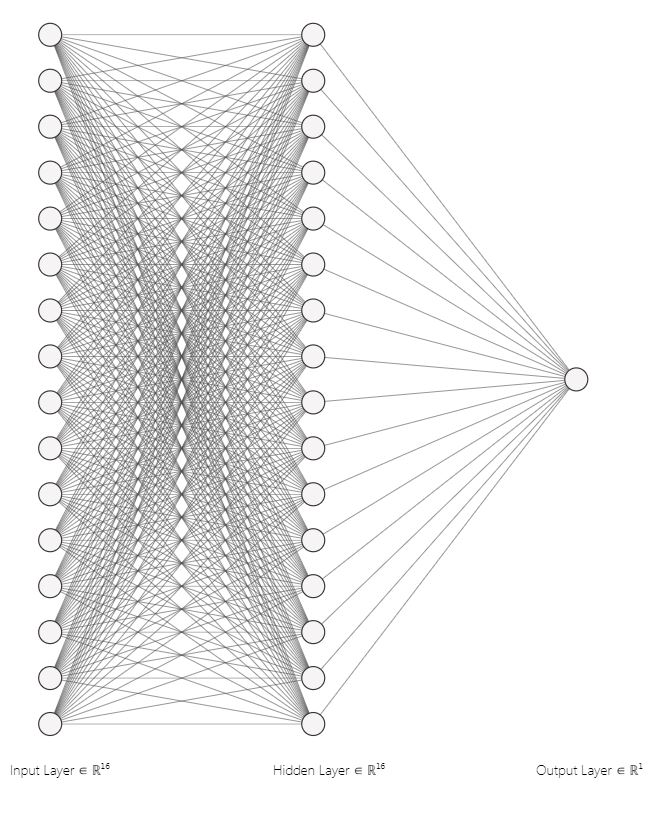

Now suppose we've decided the network architecture. Next step would be to define a loss function. This depends on the definition of $y$. If a signal like the figure above is chosen, then $l$-2 norm reconstruction error would be the suitable choice. If it's a binary value, then we'll need to use cross-entropy loss.

When we've settled on all of the required design choices, these would be the tasks:

Since the poster presentation is on Dec 15th, we need to finish the project by Dec 12th or 13th, to leave enough room for the poster preparation (and of course other projects/hw we may have :) ).

1.   Flattening the fMRI data
2.   Defining the network class in torch
3. Running SGD on the **Elastic Net** objective to get the initial results. Testing the obtained network OOD.
4. Using the AND-masked gradients like how it's done in GB's code, or do so by JAX
5. Testing the newly obtained (hopefully robust) network OOD.
6. If it had generalized well ood, then highlight the robust voxel predictors in 2D images to be included in the report.



In [2]:
!pip install nilearn

     |████████████████████████████████| 3.0MB 5.0MB/s 


In [3]:
import numpy as np 
import os
from nilearn.image import index_img, smooth_img

The datasets we will be using will be a set of nifti files, so we need a library which can read and manipulate those files into matrices. Nilearn is standard for python, and it has the tools we need to handle this type of data (see example dataset in README). We can build a list of 4D files, then read them one-by-one and extract the slices of interest. 


In [4]:
sub1_path = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/sub-01_task-stopsignal_run-01_bold.nii.gz'
sub2_path = '/content/drive/MyDrive/Mila Fall 2020/Probabilistic Graphical Models/Project/Data/sub-02_task-stopsignal_run-01_bold.nii.gz'
#sub1_path = '~/Downloads/open-neuro/sub-01/func/sub-01_task-stopsignal_run-01_bold.nii.gz'
#sub2_path = '~/Downloads/open-neuro/sub-02/func/sub-02_task-stopsignal_run-01_bold.nii.gz'

images = [sub1_path,sub2_path]

In [5]:
# list of NiftiImage objects
X = []

for index, image_path in enumerate(images):
    # load image and remove nan and inf values.
    # applying smooth_img to an image with fwhm=None simply cleans up
    # non-finite values but otherwise doesn't modify the image.
    image = smooth_img(image_path, fwhm=None)
    X.append(image)

In [6]:
print(type(X[0]))
print(type(X[0].dataobj))
X[0].shape

<class 'nibabel.nifti1.Nifti1Image'>
<class 'numpy.ndarray'>


(64, 64, 30, 182)

In [7]:
numpy_4d_img = X[0].dataobj
numpy_4d_img.shape 

(64, 64, 30, 182)

In [8]:
slice_50 = index_img(X[0], 50) # grab slice number 50 into a 
slice_50_60 = index_img(X[0], slice(50, 60)) # grab slice number 50 to 60 

slice_50.shape, slice_50_60.shape

((64, 64, 30), (64, 64, 30, 10))